<center>
    <h1>Pattern Analysis | SS20</h1>
    <hr>
    <br>
    <div style="margin:0 60px 0px 0">
        <img src="imgs/pat.jpg" width=200px align=center>
    </div>
    <h3>Exercises for </h3>
    <h2>Pattern Analysis Programming</h2>
    <br>
</center>

# Clustering: K-Means and the Gap-Statistics

`Task 4: May 27 – June 03`

- [Exercise 1 - KMeans Gap Statistics](#1) 
- [Exercise 2 - Raccoon Gap Statistics](#2) 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.spatial import distance
from scipy.ndimage.interpolation import shift
import scipy
from IPython.display import Image
import seaborn as sns

np.random.seed(42)

<a name='1'></a>

# Exercise 1

In [20]:
def kmeans(num_centers, X):
    centers = np.random.uniform(np.min(X[0]), np.max(X[0]), size=(num_centers, 2))
    
    for _ in range(10):

        assigned_to_clusters = np.zeros(len(X))

        for i, x in enumerate(X):
            closest_center = np.argmin([np.linalg.norm(x - center) for center in centers]) 
            assigned_to_clusters[i] = closest_center

        new_centers = np.array([np.mean(X[assigned_to_clusters == i], axis=0) for i in range(num_centers)])    
        convergence = np.sum(np.abs(new_centers - centers))
        centers = new_centers
    
    return np.array(new_centers), np.array(assigned_to_clusters)

In [21]:
def calculate_Wk(Ks, input_data):
    e = np.finfo(float).eps
    if(len(input_data) == 2):
        X = input_data[0]
        label = input_data[1]
    else:
        X = input_data
    
    Ks = np.arange(1,Ks+1)
    within_cluster_dists = []
    
    for K in Ks:

        dists = 0
        centroids, points = kmeans(K, X)

        for i in range(K):
            cluster_array = X[points == i]
            centroid_dist = [] 
            dist = 0

            if len(cluster_array) > 0:
                for j in range(len(cluster_array)):
                    centroid_dist.append(np.linalg.norm(centroids[i] - cluster_array[j]))

            dist += np.sum(centroid_dist)
            dists += dist + e

        within_cluster_dists.append(np.log(((dists + e) / K)))
        
        normalized_wcd = within_cluster_dists - np.max(within_cluster_dists)
    
    return normalized_wcd

In [22]:
def simulate(iterations, K):
    e = np.finfo(float).eps
    simulated_Wk = np.zeros((iterations, K)) + e 
    simulated_sk = np.zeros((iterations, K)) + e
    
    for i in range(iterations):
        
        temp_wk = []
        temp_sk = []
        
        X = np.random.uniform(0, 1, size=(300, 2))
        
        within_cluster_dists = calculate_Wk(K, X)
                    
        simulated_Wk[i] = within_cluster_dists
        
    Wks = np.mean(simulated_Wk + e, axis=0)
    sks = np.std(simulated_Wk + e, axis=0) * np.sqrt(1 + 1/20)
    
    
    return Wks, sks

In [23]:
def shift_to_one(shift, to_range):
    shifted = np.zeros(to_range)
    shifted[1:] = shift
    shifted[0] = np.nan 
    return shifted

## Start the process

In [24]:
def start_gap_statistics(simulations, Ks, input_data, input_centers):
    
    if(len(input_data) == 2):
        data = input_data[0]
        label = input_data[1]
    else:
        data = input_data
        
    colors = {0: "red", 1: "green", 2: 'blue', 3:'lightblue', 4:'yellow', 5:'pink', 6:'orange', 7:'purple',
         8:'magenta'}
    
    Wks, sks = simulate(simulations, Ks)
    within_cluster_dists = calculate_Wk(Ks, data)
    G = Wks - within_cluster_dists
    
    shifted_wks = shift_to_one(Wks, Ks+1)
    shifted_sks = shift_to_one(sks, Ks+1)
    shifted_g = shift_to_one(G, Ks+1)
    shifted_wcd = shift_to_one(within_cluster_dists, Ks+1)
    
    
    optimum = 0
    
    # THE GAP STATISTICS FORMULA FROM THE SCRIPT
    for i in range(0, len(G) - 1):
        if(G[i] >= G[i+1] + sks[i+1]):
            optimum = i
            break
    
    if optimum == 0:
        optimum = 1
        
    plt.figure(figsize=(16,10))
    
    mapped_colors = [colors[i] for i in label]
    
    # Top Left
    plt.subplot(2, 2, 1)       
    for i, x in enumerate(data):
        plt.scatter(x[0], x[1], color=mapped_colors[i], cmap='rainbow')
    
    for j in range(len(input_centers)):
        plt.scatter(input_centers[j][0], input_centers[j][1], color="black", s=150)
    
    plt.title("Original Data with {} Clusters".format(len(input_centers)))
    
    # Bottom right
    plt.subplot(2, 2, 4)        
    plt.plot(shifted_wcd, '-o', label="Drawn from Data")
    plt.plot(shifted_wks, '-o', color="green", label="Simulated")
    plt.title("Decrease of Within Cluster distance")
    
    # Bottom left
    plt.subplot(2, 2, 3)       
    plt.plot(shifted_g, '-o', color='r')
    plt.axvline(x=optimum, color='black')
    plt.title("Gap Statistics with optimum K at {}".format(optimum))
    
    # Top right    
    plt.subplot(2, 2, 2) 
    center_points, center_arrays = kmeans(optimum, data)
    centers = center_points
    color_array = center_arrays
    color = np.array([colors[x] for x in color_array])
      
    for j in range(optimum):

        points = data[color == colors[j]]
        c = colors[j]

        plt.scatter(points[:,0], points[:,1], color=c, s=20)
        plt.scatter(centers[j][0], centers[j][1], color="black", s=150)
        plt.title("Original Data with optimum {} Clusters".format(optimum))
        
    
    plt.show()

## Questions:

- `Underestimation`

If two or three clusters are very close together and the other clusters far apart, it tends to underestimate.

- `Overestimation`

If all cluster are close to together, it rather overestimates than underestimates

`In General`

It depends mostly on the random initialized centroids. When some of them get omitted due of k-means, the break in the within cluster distance forces the gap statistic to produce the optimum cluster

# Raccoon

`Upper bound | Lower bound`

## Q: the clustering on the uniform distribution leads to an upper bound of the within-cluster distances. Why is this so?

- My connection isn't so stable so I decided to type. I could say an uniform distribution looks the least cluster-like when compared with any other type of distribution. Any other probability distribution yields some regions where there are lower amount of samples. And an algorithm like k-means would certainly detect that low density area

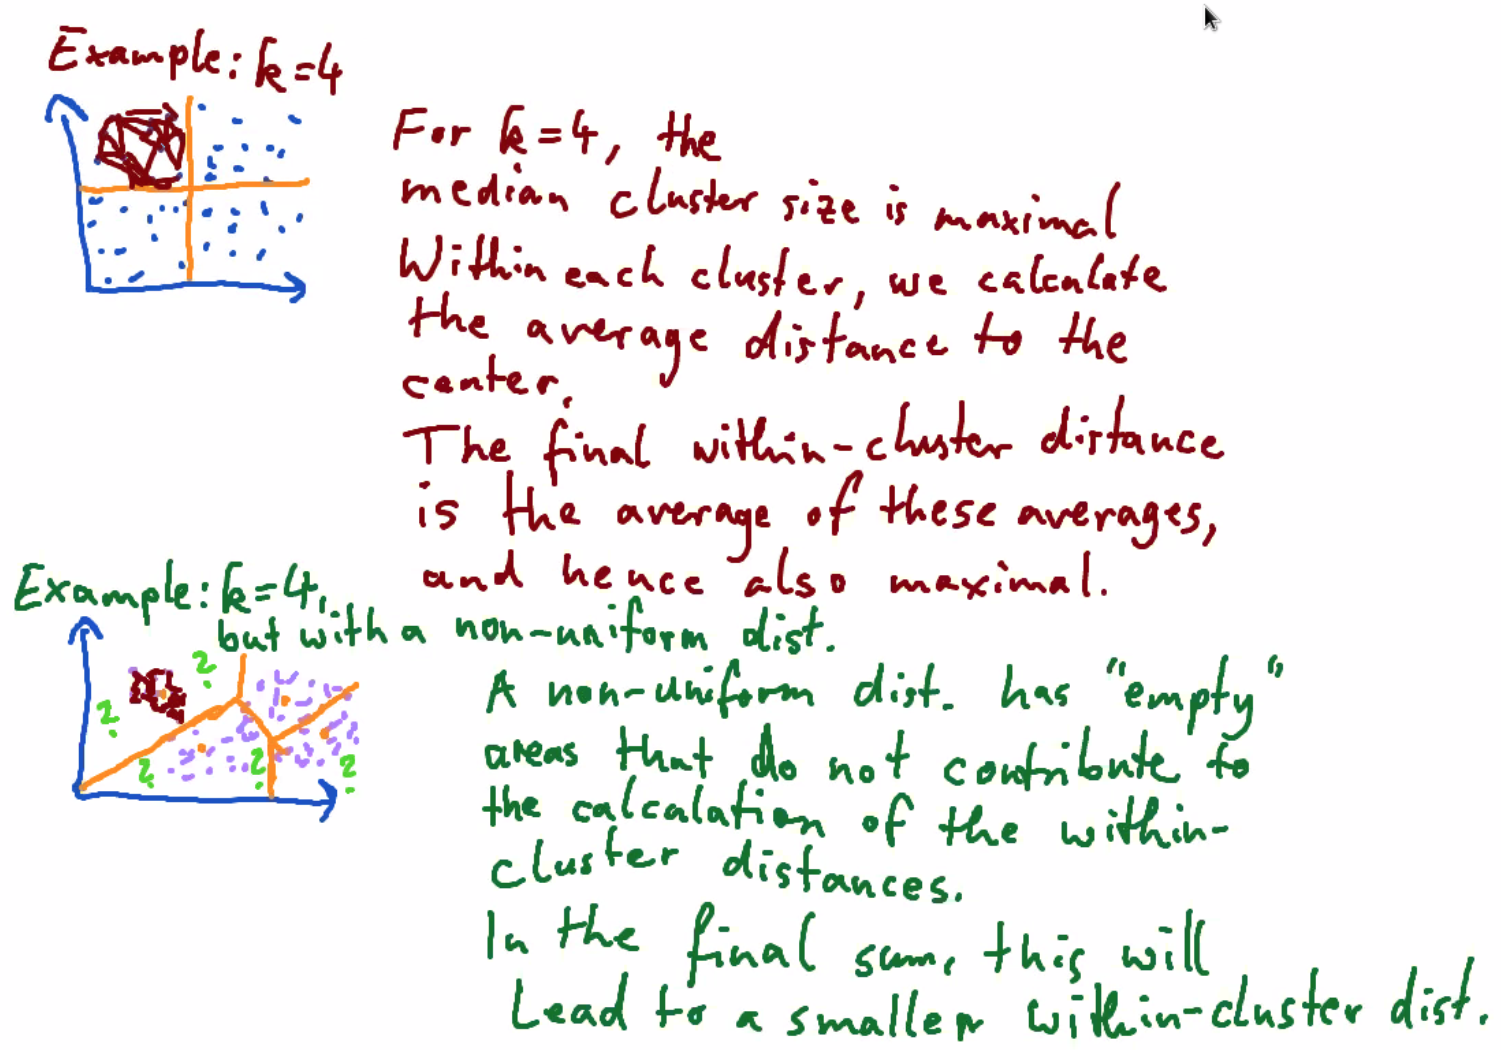

In [3]:
Image("imgs/bounds.png")

## Q: How can we enforce via the initialization that our clusters will have K non-empty components?

- initialize each cluster center at the location of a sample point
- A counter measure against the local minima

## 1st original exercise trial case

/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


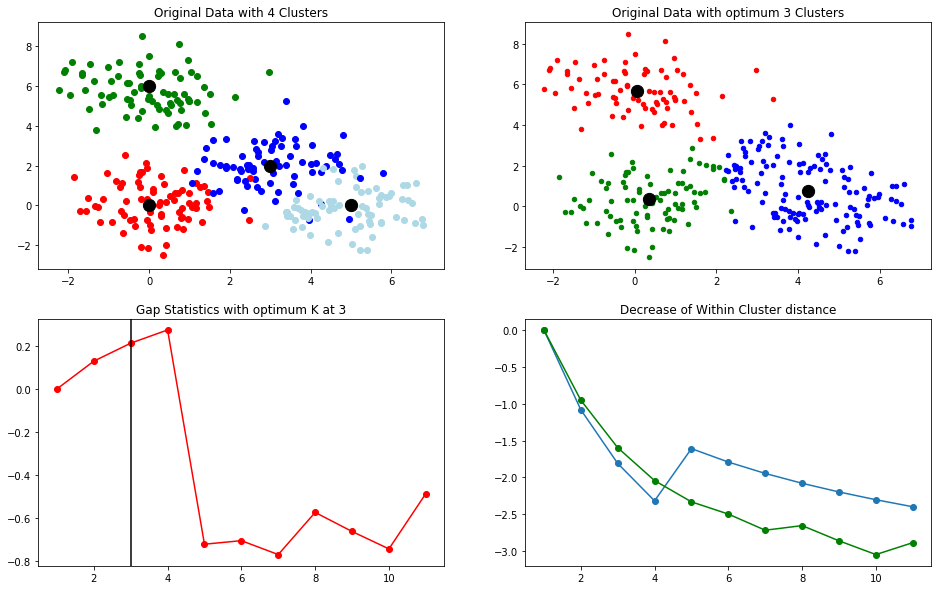

In [366]:
centers = [[0,0], [0,6], [3,2], [5,0]]
data = make_blobs(n_samples=300, centers=centers, n_features=2, cluster_std=1)

start_gap_statistics(20, 11, data, centers)

## 2nd trial case : further investigation

/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


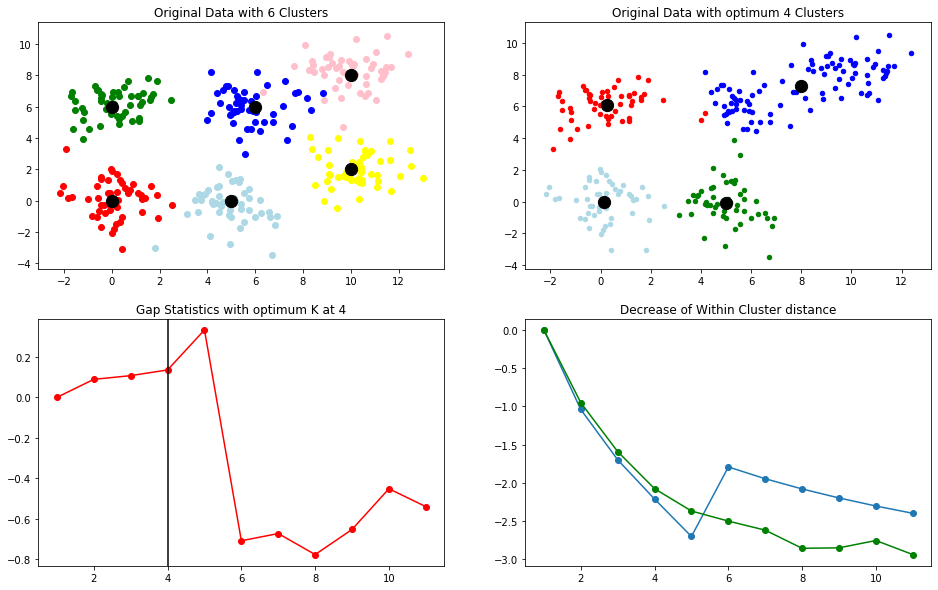

In [329]:
centers = [[0,0], [0,6], [6,6], [5,0], [10,2], [10,8]]
data = make_blobs(n_samples=300, centers=centers, n_features=2, cluster_std=1)

start_gap_statistics(20, 11, data, centers)

## 3rd trial case : further investigation

/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


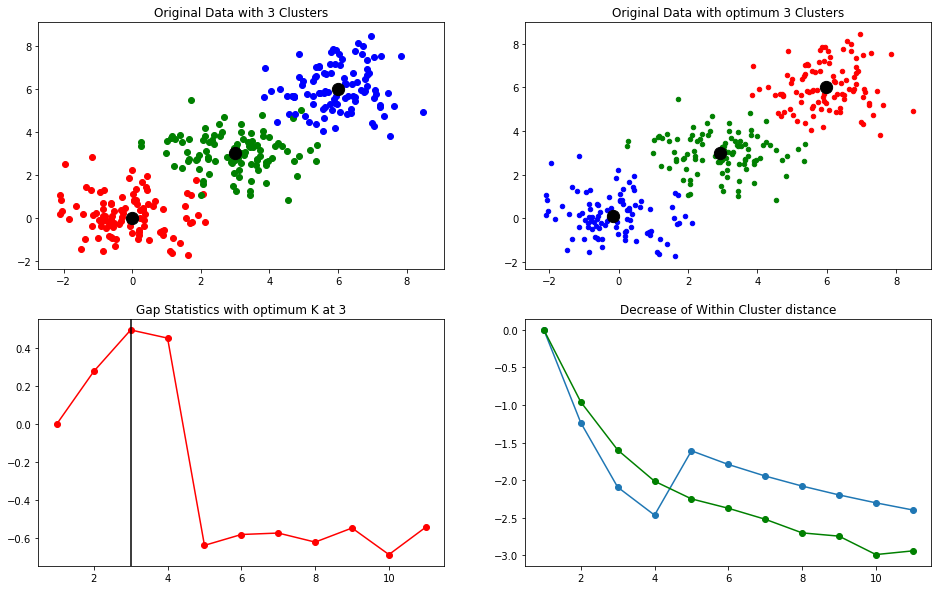

In [347]:
centers = [[0,0], [3,3], [6,6]]
data = make_blobs(n_samples=300, centers=centers, n_features=2, cluster_std=1)

start_gap_statistics(20, 11, data, centers)

## 4rd trial case : further investigation

/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


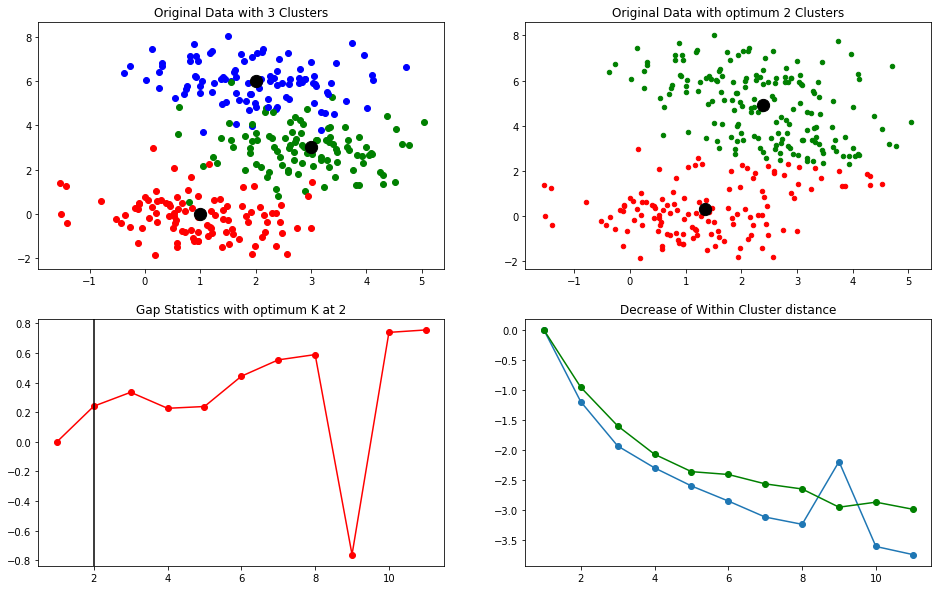

In [349]:
centers = [[1,0], [3,3], [2,6]]
data = make_blobs(n_samples=300, centers=centers, n_features=2, cluster_std=1)

start_gap_statistics(20, 11, data, centers)

## 4.2 rd trial case : further investigation

/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/timloehr/anaconda3/envs/datascience_projects/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


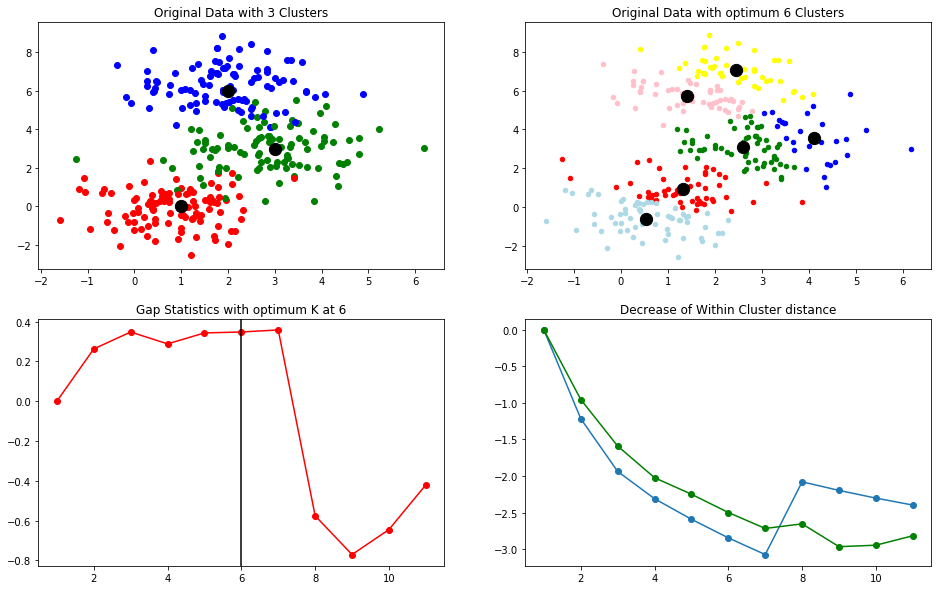

In [364]:
centers = [[1,0], [3,3], [2,6]]
data = make_blobs(n_samples=300, centers=centers, n_features=2, cluster_std=1)

start_gap_statistics(20, 11, data, centers)

<a name='2'></a>

# 2. Extra: Raccoon

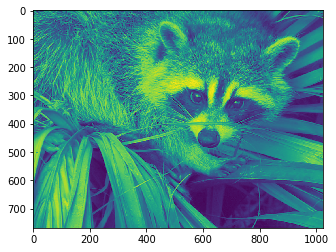

In [26]:
img = scipy.misc.face(gray=True)

plt.imshow(img);

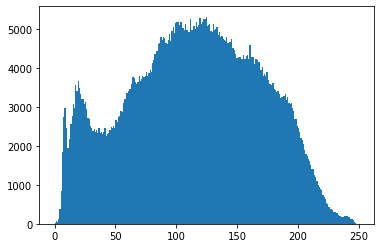

In [66]:
img_hist = plt.hist(img.flatten(), bins=250);

In [68]:
y = img_hist[0]
x = np.arange(250)

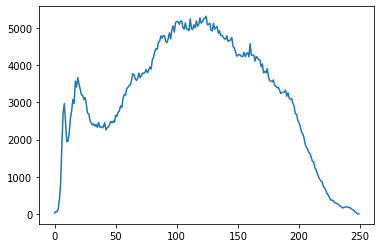

In [69]:
plt.plot(x, y)

In [71]:
cdf = np.cumsum(y)

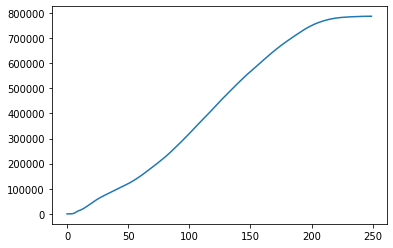

In [72]:
plt.plot(x, cdf)

In [151]:
new_cdf = np.cumsum(img.flatten())
x = np.arange(len(new_cdf))

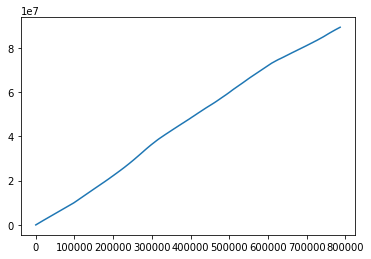

In [152]:
plt.plot(x, new_cdf)

In [103]:
rvs = np.random.uniform(np.min(cdf), np.max(cdf), 150)

new_ones = np.searchsorted(cdf, rvs)

In [104]:
zeros = np.array(np.zeros(250))

In [105]:
zeros[new_ones] = 1

In [106]:
(zeros == 0).sum()

146

In [113]:
new_centers, assigned_to_clusters = kmeans(2, zeros)

In [129]:
def kmeans(num_centers, X):
    centers = np.random.uniform(0, 250, size=(num_centers))
    
    for _ in range(10):

        assigned_to_clusters = np.zeros(len(X))

        for i, x in enumerate(X):
            closest_center = np.argmin([np.linalg.norm(x - center) for center in centers]) 
            assigned_to_clusters[i] = closest_center

        new_centers = np.array([np.mean(X[assigned_to_clusters == i], axis=0) for i in range(num_centers)])    
        convergence = np.sum(np.abs(new_centers - centers))
        centers = new_centers
    
    return np.array(new_centers), np.array(assigned_to_clusters)

In [133]:
cluster, punkte = kmeans(2, new_ones)

In [140]:
decision_boundary = cluster[0] - cluster[1]

In [145]:
sampled_img = np.where(img.flatten() < decision_boundary, 0, 1)

In [146]:
sampled_img = sampled_img.reshape(img.shape[0], img.shape[1])

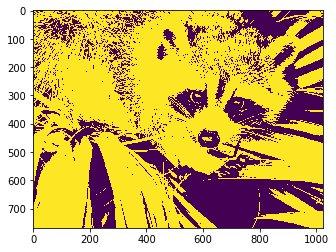

In [148]:
plt.imshow(sampled_img);